<font size="+3"><strong>Autoregressive Models</strong></font>

In [ ]:
import warnings
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px

from pymongo import MongoClient
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
warnings.simplefilter(action="ignore", category=FutureWarning)

#1 Prepare Data

##1.1 Import

In [ ]:
# Connect to the `MongoDB` server
client = MongoClient(host="localhost", port= 27017)
db = client["Air-Quality"]
dar = db["dar-es-salaam"]

In [ ]:
def wrangle(collection):
   results = collection.find(
       {"metadata.site": 11, "metadata.measurement": "P2"},
        projection={"P2": 1, "timestamp": 1, "_id": 0},
   )
   # Read data into DataFrame
   df = pd.DataFrame(list(results)).set_index("timestamp")

   # Localize timezone
   df.index = df.index.tz_localize("UTC").tz_convert("Africa/Dar_es_Salaam")

   # Remove outliers
   df = df[df["P2"] < 100]

   # Resample to 1hr window
   y = df["P2"].resample("1H").mean().fillna(method='ffill')

   return y

In [ ]:
y = wrangle(dar)
y.head()

timestamp
2018-01-01 03:00:00+03:00    9.456327
2018-01-01 04:00:00+03:00    9.400833
2018-01-01 05:00:00+03:00    9.331458
2018-01-01 06:00:00+03:00    9.528776
2018-01-01 07:00:00+03:00    8.861250
Freq: H, Name: P2, dtype: float64

## 1.2 Explore

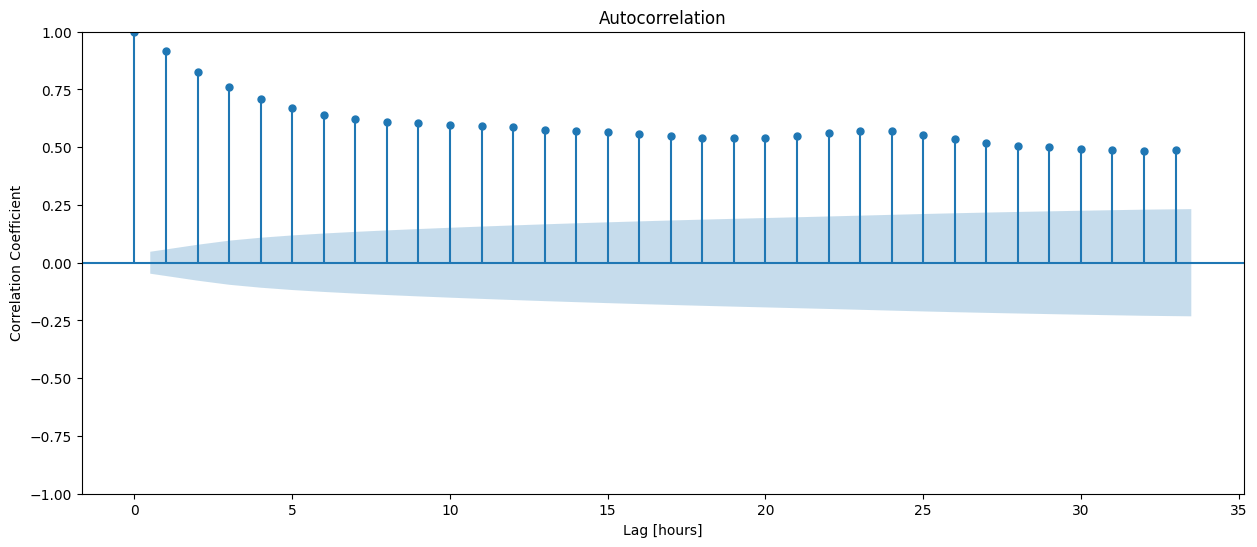

In [ ]:
# ACF plot
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y, ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");

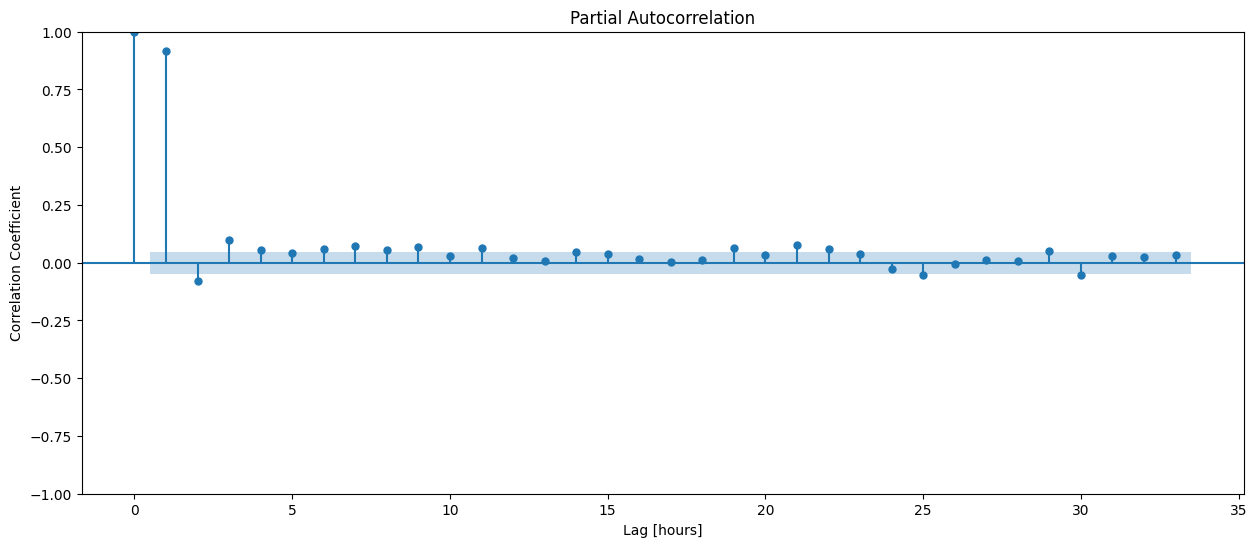

In [ ]:
# PACF plot
fig, ax = plt.subplots(figsize=(15, 6))
plot_pacf(y, ax = ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");

## 1.3 Split

In [ ]:
# Split `y` into training and test sets
cutoff_test = int(len(y) * 0.90)
y_train = y.iloc[: cutoff_test]
y_test = y.iloc[cutoff_test : ]
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (1533,)
y_test shape: (171,)


# 2 Build Model
##2.1 Baseline

In [ ]:
# The baseline mean absolute error
y_train_mean = y_train.mean()
y_pred_baseline = [y_train_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)
print("Mean P2 Reading:", round(y_train_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean P2 Reading: 8.62
Baseline MAE: 4.08


## 2.2 Iterate

In [ ]:
p_params = range(1, 31)
maes = []
for p in p_params:
    model = AutoReg(y_train, lags = p).fit()
    y_pred = model.predict().dropna()
    mae = mean_absolute_error(y_train.iloc[p:], y_pred)
    maes.append(mae)
    pass
mae_series = pd.Series(maes, name="mae", index=p_params)
mae_series.head()

1    0.947888
2    0.933894
3    0.920850
4    0.920153
5    0.919519
Name: mae, dtype: float64

In [ ]:
mae_series[mae_series==mae_series.min()].index[0]

28

In [ ]:
# Instantiate the `AutoReg` model
model = AutoReg(y_train, lags = 28).fit()

In [ ]:
# Training mean absolute error
y_pred = model.predict().dropna()
training_mae = mean_absolute_error(y_train.iloc[28:], y_pred)
print("Training MAE:", round(training_mae,2))

Training MAE: 0.91


In [ ]:
# Calculate the residuals for our model
y_train_resid = model.resid
y_train_resid.tail()

timestamp
2018-03-05 19:00:00+03:00    0.289069
2018-03-05 20:00:00+03:00    0.077362
2018-03-05 21:00:00+03:00   -0.688133
2018-03-05 22:00:00+03:00    0.265058
2018-03-05 23:00:00+03:00    3.143456
Freq: H, dtype: float64

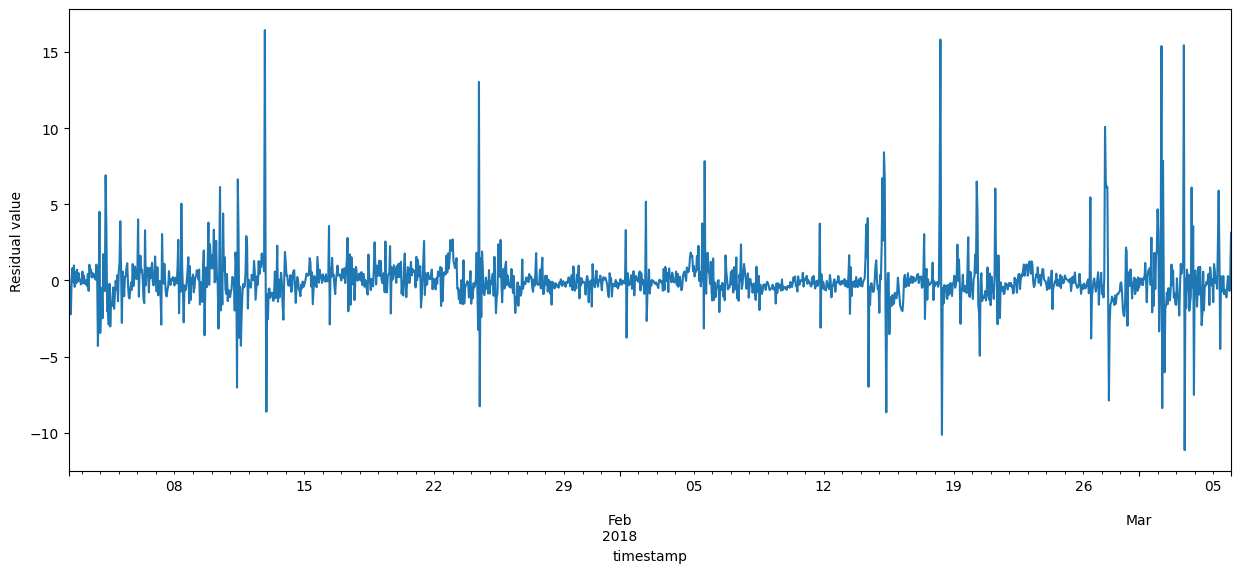

In [ ]:
# `y_train_resid` plot
fig, ax = plt.subplots(figsize=(15, 6))
y_train_resid.plot(ax=ax, ylabel="Residual value");

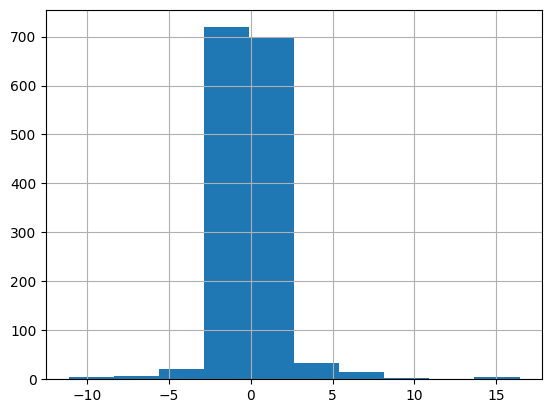

In [ ]:
# Histogram of `y_train_resid`
y_train_resid.hist()
plt.xlabel=("Residual value")
plt.ylabel=("Frequency")

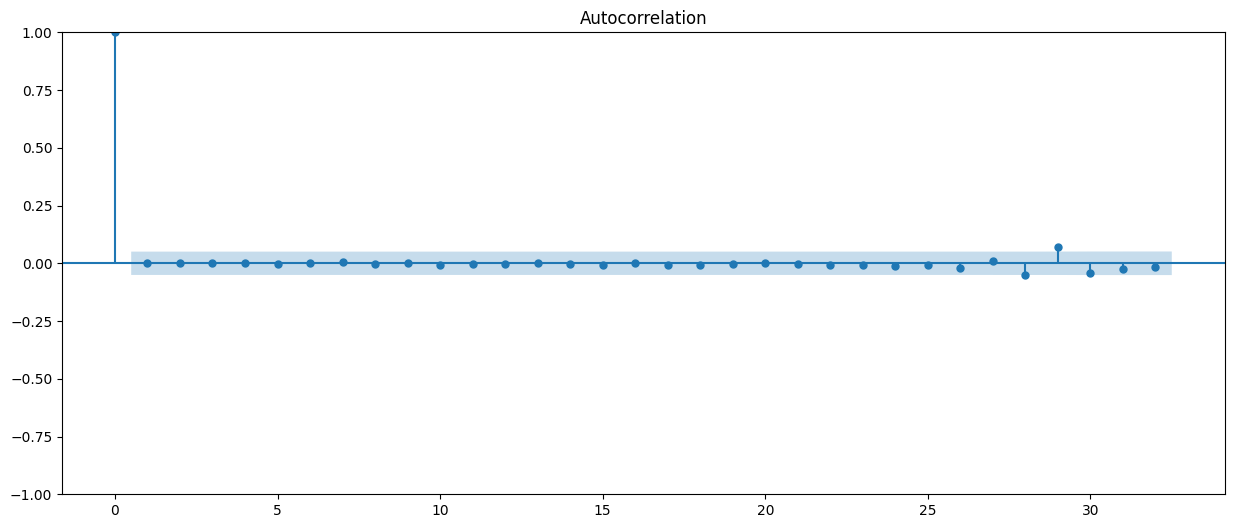

In [ ]:
# ACF plot of `y_train_resid`
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y_train_resid, ax=ax);

## 2.3 Evaluate

In [ ]:
# The test mean absolute error
y_pred_test = model.predict(y_test.index.min(), y_test.index.max())
test_mae = mean_absolute_error(y_test, y_pred_test)
print("Test MAE:", round(test_mae,2))

Test MAE: 3.96


In [ ]:
# DataFrame test_predictions that contain the true values and our model’s predictions
df_pred_test = pd.DataFrame(
      {"y_test": y_test, "y_pred": y_pred_test}, index=y_test.index
)

In [ ]:
fig = px.line(df_pred_test, labels={"value": "P2"})
fig.show()

In [ ]:
# Perform walk-forward validation for our model
%%capture

y_pred_wfv = pd.Series()
history = y_train.copy()
for i in range(len(y_test)):
    model = AutoReg(history, lags=28).fit()
    next_pred = model.forecast()
    y_pred_wfv = y_pred_wfv.append(next_pred)
    history = history.append(y_test[next_pred.index])

In [ ]:
# The test mean absolute error
test_mae = mean_absolute_error(y_test, y_pred_wfv)
print("Test MAE (walk forward validation):", round(test_mae, 2))

Test MAE (walk forward validation): 1.34


# 3 Communicate Results

In [ ]:
# The parameters for themodel
print(model.params)

const     0.255341
P2.L1     1.074481
P2.L2    -0.311770
P2.L3     0.104385
P2.L4    -0.012839
P2.L5    -0.004381
P2.L6     0.008532
P2.L7     0.004548
P2.L8     0.031278
P2.L9    -0.005847
P2.L10    0.000061
P2.L11    0.015199
P2.L12    0.048052
P2.L13   -0.081050
P2.L14    0.063548
P2.L15   -0.000738
P2.L16   -0.007511
P2.L17    0.014329
P2.L18   -0.047006
P2.L19    0.051381
P2.L20   -0.046729
P2.L21    0.047188
P2.L22   -0.000826
P2.L23    0.071372
P2.L24    0.014934
P2.L25   -0.060049
P2.L26    0.000630
P2.L27   -0.003882
P2.L28    0.004935
dtype: float64


In [ ]:
df_pred_test = pd.DataFrame(
      {"y_test": y_test, "y_pred_wfv": y_pred_wfv}
)

fig = px.line(df_pred_test, labels = {"value": "PM2.5"})
fig.show()